In [51]:
import scanpy as sc
import json
import numpy as np

In [52]:
adata = sc.read("datasets/immune_adata.h5ad")

In [53]:
with open('Genesets/Immune/BCELLS.json', 'r') as file:
    bcell_gene_set = json.load(file)
    bcell_gene_set = bcell_gene_set['genes']
    
with open('Genesets/Immune/TCELLS.json', 'r') as file:
    tcell_gene_set = json.load(file)
    tcell_gene_set = tcell_gene_set['genes']
    
with open('Genesets/Immune/MPHAGES.json','r') as file:
    mphages_gene_set = json.load(file)
    mphages_gene_set = mphages_gene_set['genes']
    
    
bcell_gene_set_final = set(adata.var_names) & set(bcell_gene_set)
print(f"Genes removed from the gene set: {len(set(bcell_gene_set) - bcell_gene_set_final)} out of {len(bcell_gene_set)}\n")

tcell_gene_set_final = set(adata.var_names) & set(tcell_gene_set)
print(f"Genes removed from the gene set: {len(set(tcell_gene_set) - tcell_gene_set_final)} out of {len(tcell_gene_set)}\n")

mphages_gene_set_final = set(adata.var_names) & set(mphages_gene_set)
print(f"Genes removed from the gene set: {len(set(mphages_gene_set) - mphages_gene_set_final)} out of {len(mphages_gene_set)}\n")

Genes removed from the gene set: 2 out of 34

Genes removed from the gene set: 2 out of 19

Genes removed from the gene set: 1 out of 33



In [54]:
adata

AnnData object with n_obs × n_vars = 173 × 27664
    obs: 'tumor_groups', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'Ground labels', 'type', 'Ground cell type', 'average link Predictions', 'ward link Predictions', 'Spectral Predictions', 'GMM Predictions', 'stromal_score', 'immune_score', 'estimate_score', 'tumor_purity', 'NMF Predictions'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'GMM Predictions_colors', 'Ground cell type_colors', 'Ground labels_colors', 'NMF Predictions_colors', 'Spectral Predictions_colors', 'average link Predictions_colors', 'dendrogram_NMF Predictions', 'dendrogram_NMF Predictions_Ground cell type', 'dendrogram_NMF Predictions_tumor_groups', 'log1p', 'neighbors', 'pca', 'tsne', 'tumor_groups_colors', 'umap', 'ward link P

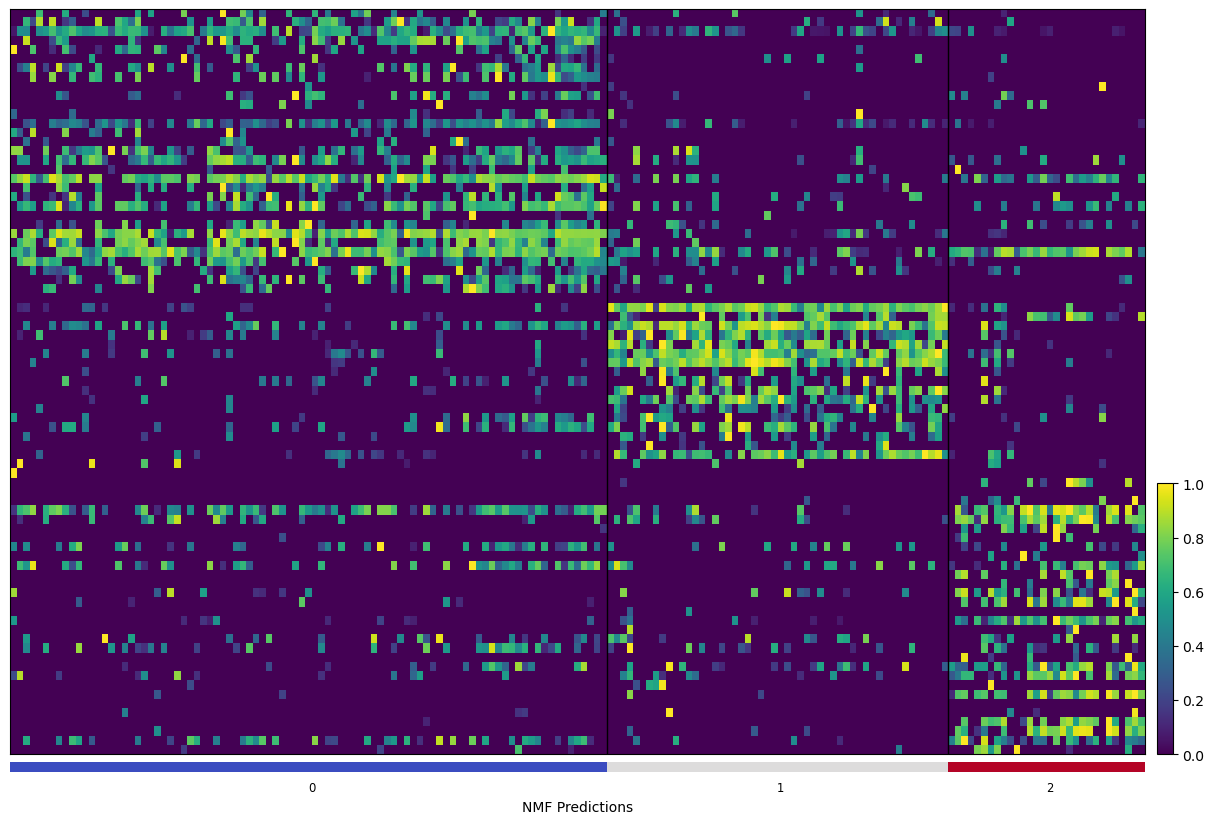

In [55]:
total_genes = list(bcell_gene_set_final) + list(tcell_gene_set_final) + list(mphages_gene_set_final)
adata = adata[:,total_genes]
sc.pl.heatmap(adata, var_names=total_genes , groupby='NMF Predictions', use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

From the above its evident that the cluster with label 0 expresses the BCELL related geneset, cluster 1 expresses the TCELL related geneset and cluster 2 expresses the Macrophage related geneset. Thus we can name the clusters accordingly.

In [56]:
adata.obs['NMF Predictions']

BC02_60       2
BC03_03       0
BC03_06       0
BC03_24       0
BC03_25       1
             ..
BC09_Re_94    1
BC09_Re_95    1
BC10_07       2
BC10_43       2
BC11_28       1
Name: NMF Predictions, Length: 173, dtype: category
Categories (3, object): ['0', '1', '2']

In [57]:
label_mapping = {'0': "B-CELL", '1': "T-CELL", '2': "MP-CELL"}
adata.obs['NMF Predictions'] = [label_mapping[label] for label in adata.obs['NMF Predictions']]

/tmp/ipykernel_62569/3168979202.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['NMF Predictions'] = [label_mapping[label] for label in adata.obs['NMF Predictions']]


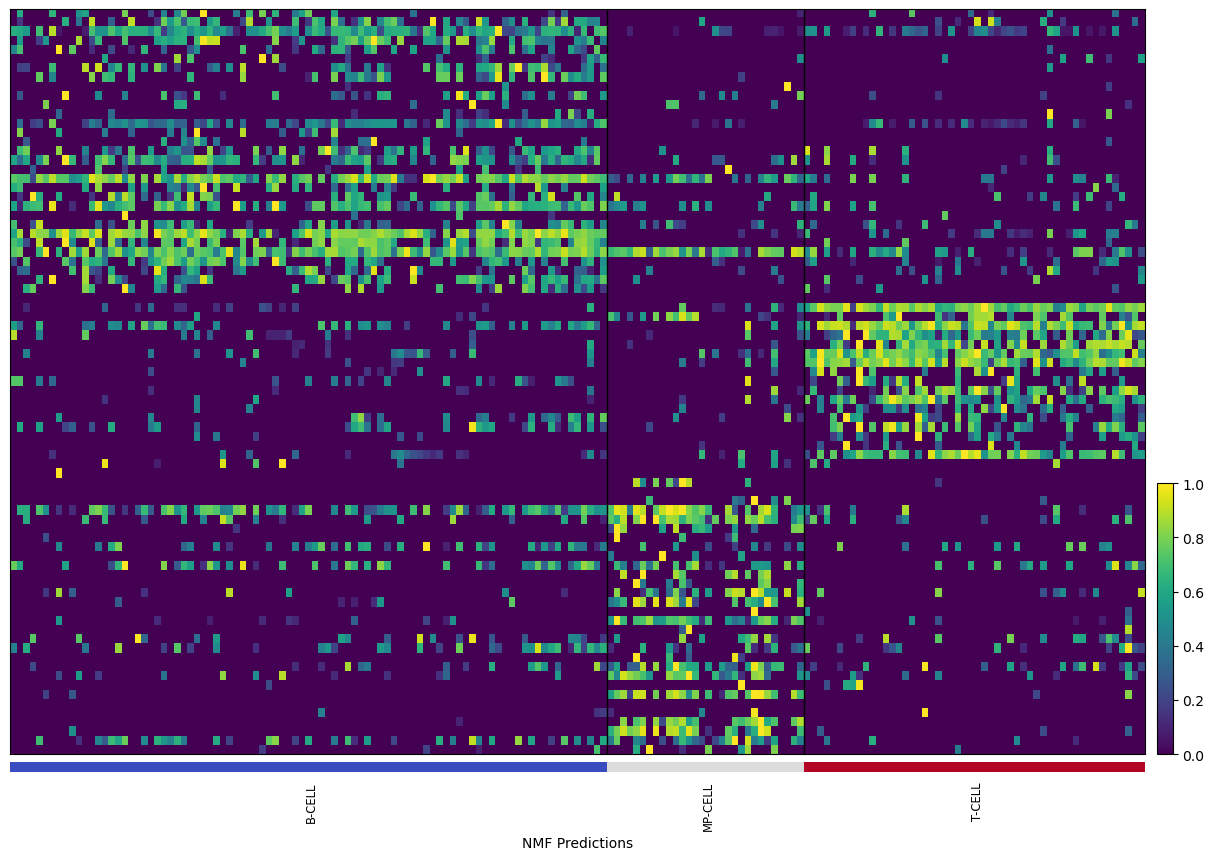

In [58]:
sc.pl.heatmap(adata, var_names=total_genes , groupby='NMF Predictions', use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')

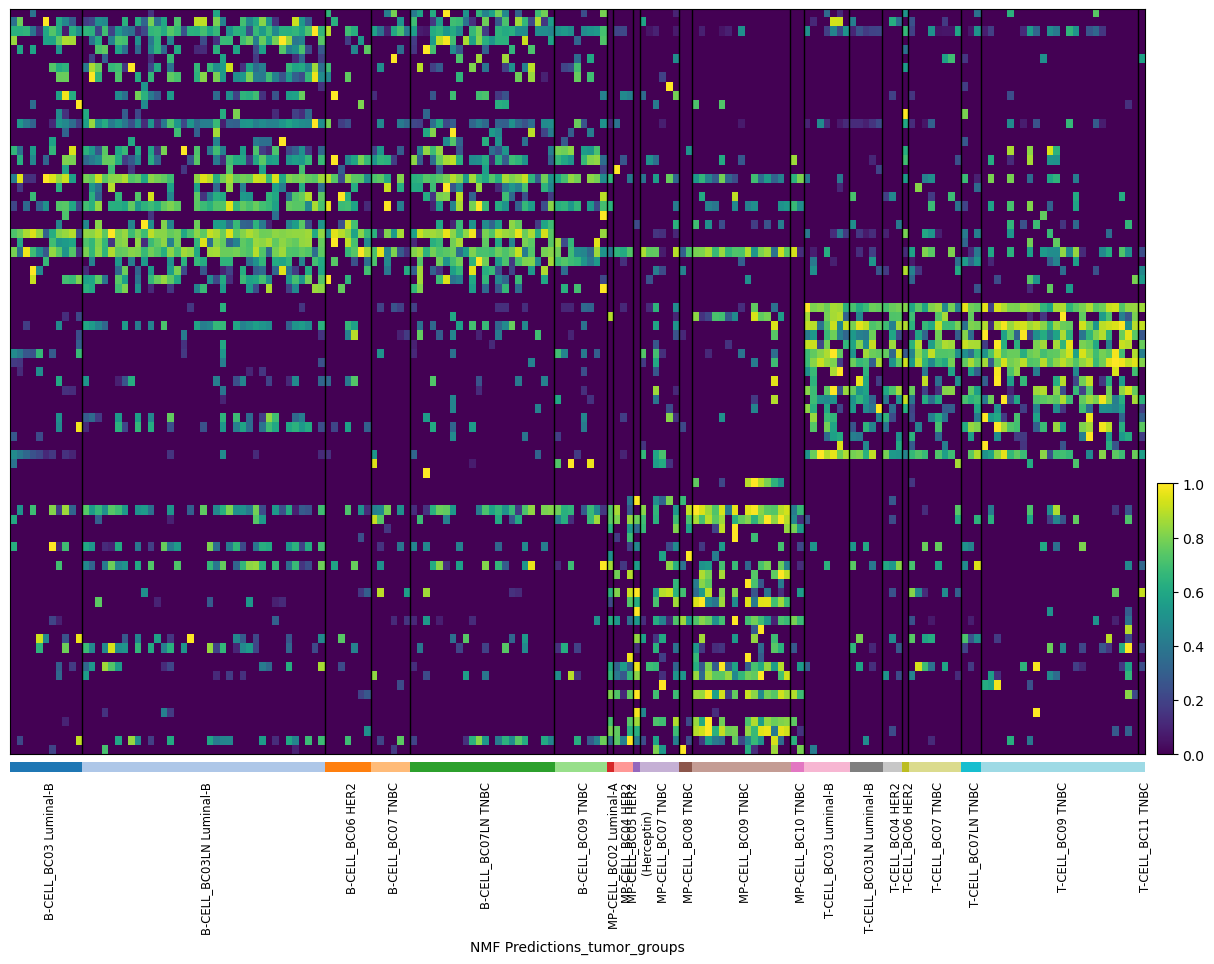

In [59]:
sc.pl.heatmap(adata, var_names=total_genes , groupby=['NMF Predictions','tumor_groups'], use_raw=False, show=True,swap_axes=True, figsize=(15,10),standard_scale='var')